### 1D Discrete Fourier Transform  

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

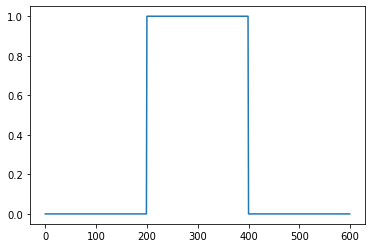

In [2]:
#Input rectangular function
x = np.arange(-3, 3, 0.01)
y = np.zeros(len(x))
y[200:400] = 1


plt.plot(y)
plt.show()

/home/orkhan/.virtualenvs/computer-vision-tutorial/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


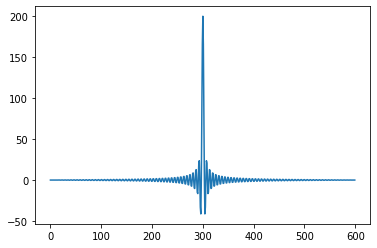

In [3]:
#Fourier Transform
yShift = np.fft.fftshift(y)
fftyShift = np.fft.fft(yShift)
ffty = np.fft.fftshift(fftyShift)

plt.plot(ffty)
plt.show()

### 2D Image Fourier Transform with Numpy and Opencv

In [4]:
def show(img):
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

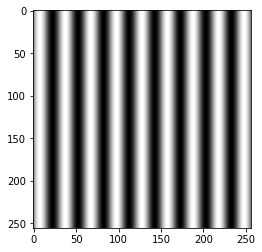

In [5]:
#Generate a 2D sine wave image
x = np.arange(256) #generate values from 0 to 255 (our image size)
frequency = 30 #set to smaller number to increase the frequency
y = np.sin(2 * np.pi * x / frequency) # calculate sine of x values

#Offset sine wave by the max value to go out of negative range of sine
y += max(y)

#Generate a 256x256 image (2D array of the sine wave)
img = np.array([[y[j]*127 for j in range(256)] for i in range(256)], dtype=np.uint8)
plt.imshow(img, cmap="gray")

In [6]:
def visualize_magnitude_spectrum(dft):
    magnitude_spectrum = 20 * np.log(np.abs(dft))
    magnitude_spectrum = np.int8(magnitude_spectrum)

    plt.imshow(magnitude_spectrum, cmap="gray")

#### Numpy way

/tmp/ipykernel_12161/881733894.py:2: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(dft))


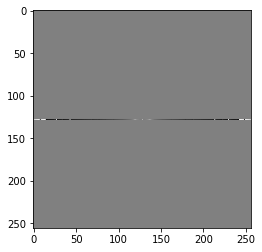

In [7]:
#Get complext number fourier transform which has vector k - frequency and orientation
numpy_dft = np.fft.fft2(img)
#Shift low frequency to the center
numpy_dft_shift = np.fft.fftshift(numpy_dft)
#Only for visualization purpose
visualize_magnitude_spectrum(numpy_dft_shift)

#### OpenCV way

In [8]:
#Apply Discrete Fourier Transform with Opencv, make sure image type converted to float32
#will output Complex numbers - Complex output returns k vector with magnitude and orientation
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT) 

/tmp/ipykernel_12161/1075862338.py:5: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log((cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])))


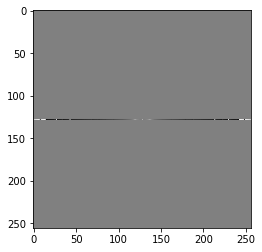

In [9]:
#Shift low frequency to the center
dft_shift = np.fft.fftshift(dft)
#To visualize returned magnitude spectrum we use log
#dft_shift[:,:,0] - real number, dft_shift[:,:,1] - imaginary number
magnitude_spectrum = 20 * np.log((cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])))
plt.imshow(magnitude_spectrum.astype(np.int8), cmap="gray")

### Low Pass Filter - masking high freq area - blurring image

In [10]:
img = cv2.imread('../assets/moon.png', 0) # load an image

#Output is a 2D complex array. 1st channel real and 2nd imaginary
#For fft in opencv input image needs to be converted to float32
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#Rearranges a Fourier transform X by shifting the zero-frequency 
#component to the center of the array.
#Otherwise it starts at the tope left corenr of the image (array)
dft_shift = np.fft.fftshift(dft)

##Magnitude of the function is 20.log(abs(f))
#For values that are 0 we may end up with indeterminate values for log. 
#So we can add 1 to the array to avoid seeing a warning. 
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

In [11]:
# Circular LPF mask, center circle is 1, remaining all zeros
# Only allows low frequency components - smooth regions
#Can smooth out noise but blurs edges.

rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r = 40
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 1

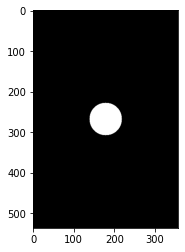

In [12]:
#Mask image
plt.imshow(mask[:,:, 0], cmap="gray")

In [13]:
# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = dft_shift * mask

/tmp/ipykernel_12161/1473198909.py:2: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


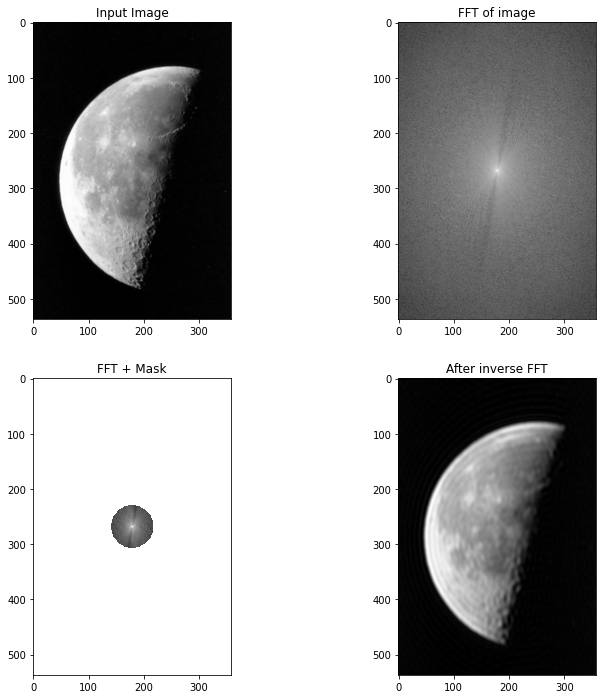

In [14]:
#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
img_back = cv2.idft(f_ishift)

#Magnitude spectrum of the image domain
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()


### High Pass Filter - masking low frea area center - detecting edges

In [15]:
# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.ones((rows, cols, 2), np.uint8)
r = 20
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0

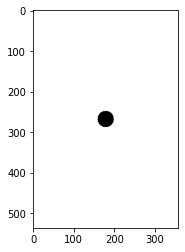

In [16]:
plt.imshow(mask[:, :, 0], cmap="gray")

In [17]:
# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = dft_shift * mask

/tmp/ipykernel_12161/1745291996.py:2: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


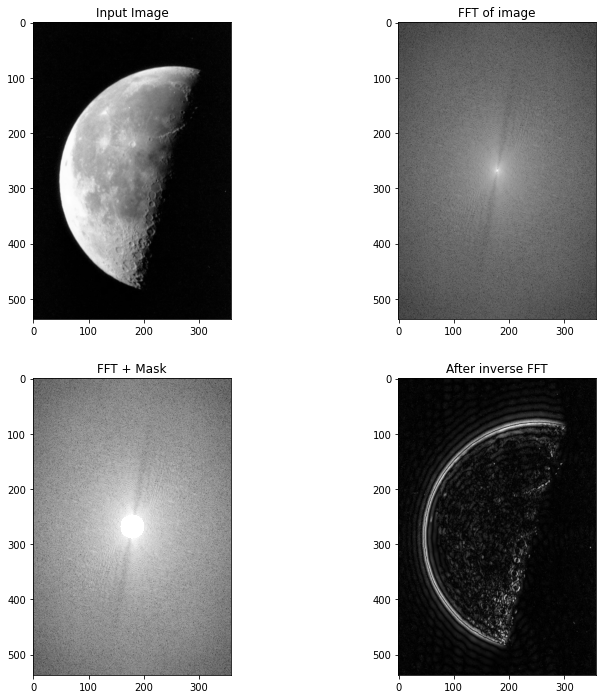

In [18]:
#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
img_back = cv2.idft(f_ishift)

#Magnitude spectrum of the image domain
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()

### Band Pass Filter

**The Band-Pass Filter will allow you to reduce the frequencies outside of a defined range of frequencies. We can think of it as low-passing and high-passing at the same time.**

In [19]:
# Band Pass Filter - Concentric circle mask, only the points living in concentric circle are ones
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)
mask = np.zeros((rows, cols, 2), np.uint8)
r_out = 80
r_in = 10
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                           ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
mask[mask_area] = 1

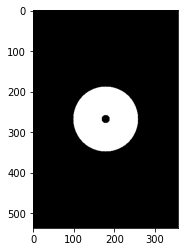

In [20]:
plt.imshow(mask[:,:,0], cmap="gray")

In [21]:
# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = dft_shift * mask

/tmp/ipykernel_12161/1473198909.py:2: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


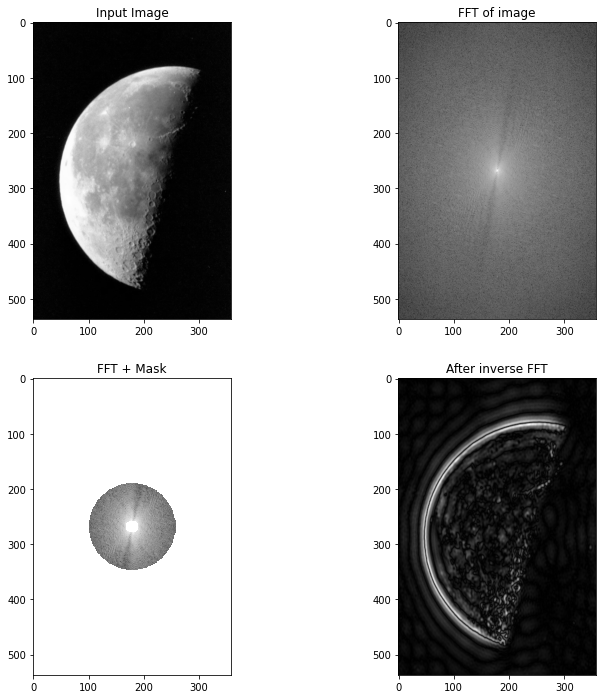

In [22]:
#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
img_back = cv2.idft(f_ishift)

#Magnitude spectrum of the image domain
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()


Can create Hybrid images from 2 images. One of the image should get Low Pass Filter, and another High Pass filter.
After summing up images you get the `hybrid` image. Looking closer to the image, you will see High Frequnecy information, while looking from afar your eyes will perceive low frequency information.

*************